# Finding Neptune using Uranus

Note :
  -  For better understanding of ths notebook, refer to the [md_file](https://github.com/inlab-geo/cofi-examples/blob/main/theory/finding_neptune_deterministic.md) designed specifically for this notebook and better insights into the theory.
  
  - The import methods and functions from [neptune_deterministic_methods](https://github.com/inlab-geo/cofi-examples/blob/main/theory/finding_neptune_deterministic.md) are used to set up the simulation and perform the necessary calculations.

In [ ]:
# This notebook requires the following libraries to run. In order to install them uncomment the lines below
# %pip install cofi
# %pip install numba
# %pip install tqdm
# %pip install matplotlib
# %pip install astroquery

#also make sure you have the neptune_deterministic_methods.py file in the same directory as this notebook.

## 1. Introduction

- The following Notebook is based on the historical problem on how Neptune was found by Johann Galle using mathematical predictions made independently by two astronomers:

  - Urbain Le Verrier (France)

  - John Couch Adams (England)
  
  Through this Notebook we wish to demostrate how `CoFI` can be used to solve this problem via deterministic inversion.
  For more details on this problem, see the following [thesis](www.diva-portal.org/smash/get/diva2:1218549/FULLTEXT01.pdf)

- In the following notebook we discuss the problem of finding Neptune's mass, its velocity components and its position coordinates in the year 1775, by modeling the trajectory of Uranus with and without the influence of Neptune.     

- We define $ g(m) $, our forward model, as vector-valued function that predicts the position coordinates of Uranus at each observation time $t_j$, as a function of Neptune's parameters $m$:

    $$
     g(m) =
    \begin{bmatrix}
    \hat x_1(m) \\
    \vdots \\
    \hat x_N(m) \\
    \hat y_1(m) \\
    \vdots \\
    \hat y_N(m) \\
    \hat z_1(m) \\
    \vdots \\
    \hat z_N(m)
    \end{bmatrix}
    \in \mathbb{R}^{3M \times 1}
    $$
    where $ N $ is the number of data points, and $ \hat x_j(m), \ \hat y_j(m), \ \hat z_j(m) $ are the coordinates of Uranus at data point $ j \ = \ 1, \ 2, \ .... \ N$ as a function of Neptune's parameters $ m $,        
    where $m = (m_M, m_x, m_y, m_z, {m_{v_x}}, m_{v_y}, m_{v_z})$ is the set of parameters describing Neptune's mass ($m_M$), its position coordinates $(m_x, m_y, m_z)$ and its velocity components $(m_{v_x}, m_{v_y}, m_{v_z})$
    

    and $d$ as the data vector of positions of Uranus at different time steps:  
    $$
    d =
    \begin{bmatrix}
    x_1 \\
    \vdots \\
    x_N \\
    y_1 \\
    \vdots \\
    y_N \\
    z_1 \\
    \vdots \\
    z_N
    \end{bmatrix}
    \in \mathbb{R}^{3M \times 1}
    $$
    where $ N $ is the number of data points, and $ \hat x_j, \ \hat y_j, \ \hat z_j $ are the true coordinates of Uranus at data point $ j \ = \ 1, \ 2, \ .... \ N$.
    
 - hence our problem formulation changes to : 
  $$
    \underset{m}{\min}   || g(m) - {d} ||_{2}^2 
  $$


## 2. Problem Setting

- This formulation uses Newton’s Law of Universal Gravitation to model the **net gravitational influence** from multiple bodies on a single target planet.


- This results in the system of differential equations:

    $$
    \frac{d}{dt}
    \begin{bmatrix}
    \mathbf{r}(t) \\
    \mathbf{v}(t)
    \end{bmatrix}
    = 
    \begin{bmatrix}
    \mathbf{v}(t) \\
    \mathbf{a}(t)
    \end{bmatrix}
    $$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Callable
import copy
from numba import njit, jit
import warnings
warnings.filterwarnings('ignore')

from cofi import BaseProblem, InversionOptions, Inversion

np.random.seed(42)

- We solve our ODEs with the **Runge-Kutta 4 (RK4)** method, which is an explicit and iterative method, well-suited for initial value problems.

- In the following cell, we import -  `acceleration` and `rk4_step` to serve as functions for our forward model.

- We now demostrate our forward model, using the above defined functions, in the `run_simulation` method, which helps us run a simulation of solar system.



- Throughout this notebook for the purpose of our inversion, we are going to define mass in terms of solar masses, positions coordinates in **Astonomical Units (AU)** and velocities for planets in **Au/day**

Computing trajectories...: 100%|██████████| 36500/36500 [00:00<00:00, 140327.49it/s]


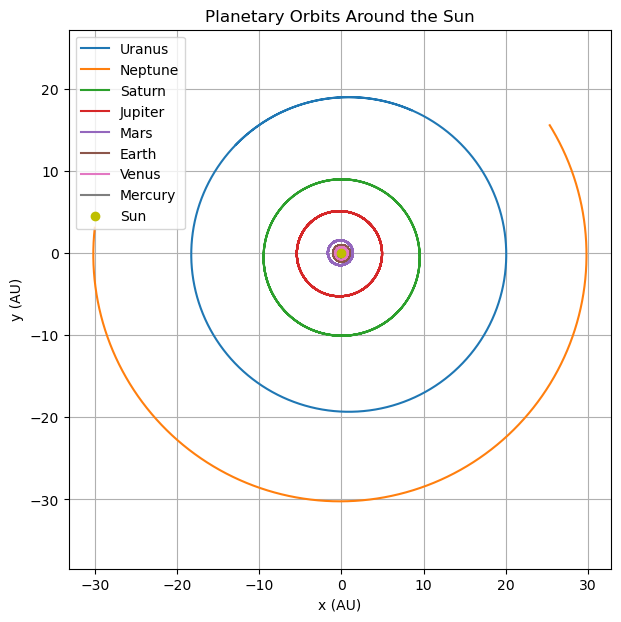

In [24]:
from neptune_deterministic_methods import acceleration, rk4_step, run_simulation
trajectories = run_simulation(T = 100, dt = 1, plot_only=['Uranus', 'Neptune', 'Saturn', 'Jupiter', 'Mars', 'Earth', 'Venus', 'Mercury'])

## 3. Inversion on Synthetic Data

- We will first demonstrate the use of our deterministic inversion using `CoFI` on synthetic data. We are going to use `levenberg-marqudt method` to solve this deterministic inversion problem. 
- The synthetic observations are generated by integrating our gravitational forward model with a fourth-order Runge-Kutta (`RK4`) solver to simulate Uranus's trajectory under the influence of Neptune.


- We simulate observational noise by sampling from zero-mean Gaussian distributions with specified variances for each coordinate:

$$
x_\text{obs} = x + \epsilon_x, \quad y_\text{obs} = y + \epsilon_y, \quad z_\text{obs} = z + \epsilon_z
$$

- where

- $$
    \epsilon_x \sim \mathcal{N}(0, \sigma_x^2), \quad 
    \epsilon_y \sim \mathcal{N}(0, \sigma_y^2), \quad 
    \epsilon_z \sim \mathcal{N}(0, \sigma_z^2)
  $$

- with noise levels set as

- $$
  \sigma_x = \sigma_y = 10^{-3}, \quad \sigma_z = 10^{-5}
  $$

- The function below generates the synthetic data with the specified noise levels.

In [5]:
from neptune_deterministic_methods import generate_synthetic_data

T = 190 # time for which we want to generate synthetic data
z_scale_factor = 1
dt = 1

U_true = generate_synthetic_data(T = T, 
                                 dt = dt, 
                                 z_scaling = False, 
                                 add_noise = True, 
                                 noise_level = np.array([0.001, 0.001, 0.00001]))

Computing trajectories...: 100%|██████████| 68985/68985 [00:00<00:00, 135708.80it/s]



Synthetic data ranges:
X: -18.298 to 20.084 (range: 38.383)
Y: -19.319 to 19.019 (range: 38.337)
Z: -0.272199 to 0.248322 (range: 0.520521)

Noisy synthetic data ranges:
X: -18.299 to 20.084 (range: 38.383)
Y: -19.321 to 19.020 (range: 38.340)
Z: -0.272212 to 0.248322 (range: 0.520534)


In [6]:
# True/reference parameters for Neptune [mass, x, y, z, vx, vy, vz]
from setup_inversion import get_inversion_indices, set_true_m, unscale_param, get_param_bounds, get_starting_points, get_param_scales, validate_config, set_initial_conditions     

m_0 = set_true_m()
initial_conditions = set_initial_conditions()
PARAM_BOUNDS = get_param_bounds()
PARAM_SCALES = get_param_scales()

- Cell below is used for validating our setup and setting up the scaling and unscaling functions, along with a `build_neptune_vector` method that helps us build the scaled version of our model depending on what we are inverting for. For example - if it's just the mass then all other parameters, velocities and positions, would be derived from the true values.

In [7]:
validate_config()

Inverting for: ['mass', 'x', 'y', 'z', 'vx', 'vy', 'vz']
Starting points: [5.129494593915012e-05, -29.91585533802299, 3.145551080953517, 0.1050744172524112, -0.0002804329678559355, -0.00311021549555015, 4.187313350941659e-05]


In [8]:
names = list(initial_conditions.keys())
n_bodies = len(names)
uranus_idx = names.index("Uranus")

- In the cell below, the `predict_U` method defines our full forward model and uses the `acceleration` and the `rk4_step` methods defined previously.  


- We also use the `jacobian` and the `residual` methods below, to be used by `CoFI` for inversion.

- The cell below sets up the starting model for our inversion and some pre-defined scales to be used for scaling while running our inversion.

In [9]:
from setup_inversion import scale_param, get_starting_points
from neptune_deterministic_methods import predict_U, residual, jacobian

INVERT_INDICES = get_inversion_indices()
STARTING_POINTS = get_starting_points()
z_scale_factor = 1

m_start_scaled = scale_param(np.array(STARTING_POINTS))
if len(INVERT_INDICES) == 1:
    Nmstart_scaled = m_start_scaled.item() if hasattr(m_start_scaled, 'item') else m_start_scaled

print(f"\nStarting points (unscaled): {STARTING_POINTS}")
print(f"Starting points (scaled): {m_start_scaled}")

print("\nTesting forward function...")
try:
    pred_test = predict_U(m_start_scaled, T=T, dt=dt, z_scale_factor=z_scale_factor)
    residual_test = residual(m_start_scaled, U_true, T=T, dt=dt)
    print(f"Initial residual norm: {np.linalg.norm(residual_test):.6f}")
    print(f"Residual by component:")
    print(f"  X component: {np.linalg.norm(residual_test[:T]):.6f}")
    print(f"  Y component: {np.linalg.norm(residual_test[T:2*T]):.6f}")
    print(f"  Z component: {np.linalg.norm(residual_test[2*T:]):.6f}")
except Exception as e:
    print(f"Forward function test failed: {e}")
    import traceback
    traceback.print_exc()




Starting points (unscaled): [5.129494593915012e-05, -29.91585533802299, 3.145551080953517, 0.1050744172524112, -0.0002804329678559355, -0.00311021549555015, 4.187313350941659e-05]
Starting points (scaled): [ 1.83825353e-04 -4.59414276e+00  4.33575690e-01  6.82916330e-02
 -2.24204674e-01 -3.74160049e+00  2.81992340e-03]

Testing forward function...
Initial residual norm: 0.057933
Residual by component:
  X component: 0.043213
  Y component: 0.038579
  Z component: 0.000743


## 3.1 Running the Inversion on Synthetic Data

In [10]:
inv_problem = BaseProblem()
inv_problem.name = "Neptune Orbit Determination - Config Driven"
inv_problem.set_data(U_true)
inv_problem.set_forward(predict_U, args = [T, dt])
inv_problem.set_initial_model(np.atleast_1d(m_start_scaled))
inv_problem.set_residual(residual, args = (U_true, 0, T, dt))  # Pass U_true as an argument to residual function
inv_problem.set_jacobian(jacobian, args = (U_true, 0, T, dt))  # Pass U_true as an argument to jacobian function
bounds_lower_scaled = scale_param(np.array([bound[0] for bound in PARAM_BOUNDS]))
bounds_upper_scaled = scale_param(np.array([bound[1] for bound in PARAM_BOUNDS]))

inv_options = InversionOptions()
inv_options.set_tool("scipy.optimize.least_squares")
inv_options.set_params(
    # bounds=(bounds_lower_scaled, bounds_upper_scaled),    # Uncomment to use bounds when using trust region reflective method
    method="trf",   # Trust Region Reflective method, you can also try 'lm' (Levenberg-Marquardt) if you prefer
    max_nfev=100,
    verbose=2,
    ftol=1e-12,
    xtol=1e-12
)

print("\nRunning inversion...")
try:
    inv = Inversion(inv_problem, inv_options)
    inv_result = inv.run()
    result = inv_result.model
    result_unscaled = unscale_param(result)
    
    print("\n" + "="*50)
    print("RESULTS")
    print("="*50)
    
    param_names = ['mass', 'x', 'y', 'z', 'vx', 'vy', 'vz']
    result_unscaled = np.atleast_1d(result_unscaled)
    
    print("\nInverted parameters:")
    for i, param_idx in enumerate(INVERT_INDICES):
        param_name = param_names[param_idx]
        estimated = result_unscaled[i]
        true_val = m_0[param_idx]
        starting = STARTING_POINTS[i]
        
        print(f"  {param_name}: {estimated:.6e} (true: {true_val:.6e})")
    
    final_pred = predict_U(result, T, dt)
    final_residual = U_true - final_pred
    print(f"\nFinal residual norm: {np.linalg.norm(final_residual):.6f}")
    print(f"Final residual by component:")
    print(f"  X component: {np.linalg.norm(final_residual[:T]):.6f}")
    print(f"  Y component: {np.linalg.norm(final_residual[T:2*T]):.6f}")
    print(f"  Z component: {np.linalg.norm(final_residual[2*T:]):.6f}")
    
    print(f'initial residual norm: {np.linalg.norm(residual(m_start_scaled, U_true)):.6f}')
    print(f'final residual norm: {np.linalg.norm(final_residual):.6f}')
    
    
    if 0 in INVERT_INDICES:
        mass_idx = INVERT_INDICES.index(0)
        neptune_mass = result_unscaled[mass_idx]
        print(f"\nEstimated Neptune mass: {neptune_mass:.6e} solar masses")
        print(f"Estimated Neptune mass: {neptune_mass * 1.989e30:.6e} kg")
    
    print("Inversion completed successfully!")
    print("="*50)
    
except Exception as e:
    print(f"Inversion failed: {e}")
    import traceback
    traceback.print_exc()



Running inversion...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.6781e-03                                    5.11e+01    
       1              2         8.3576e-04      8.42e-04       2.62e-02       3.32e+00    
       2              3         3.4406e-04      4.92e-04       5.24e-02       8.38e+00    
       3              5         3.0936e-04      3.47e-05       9.10e-03       4.53e+00    
       4              6         3.0036e-04      8.99e-06       2.27e-03       2.17e+00    
       5              7         2.9811e-04      2.25e-06       5.69e-04       1.38e-01    
       6              8         2.9681e-04      1.30e-06       1.42e-04       1.51e+00    
       7             14         2.9678e-04      2.81e-08       1.39e-07       3.08e-01    
       8             22         2.9678e-04      0.00e+00       0.00e+00       3.08e-01    
`xtol` termination condition is satisfied.
Function evaluations 22, 

## 3.2 Plotting the results

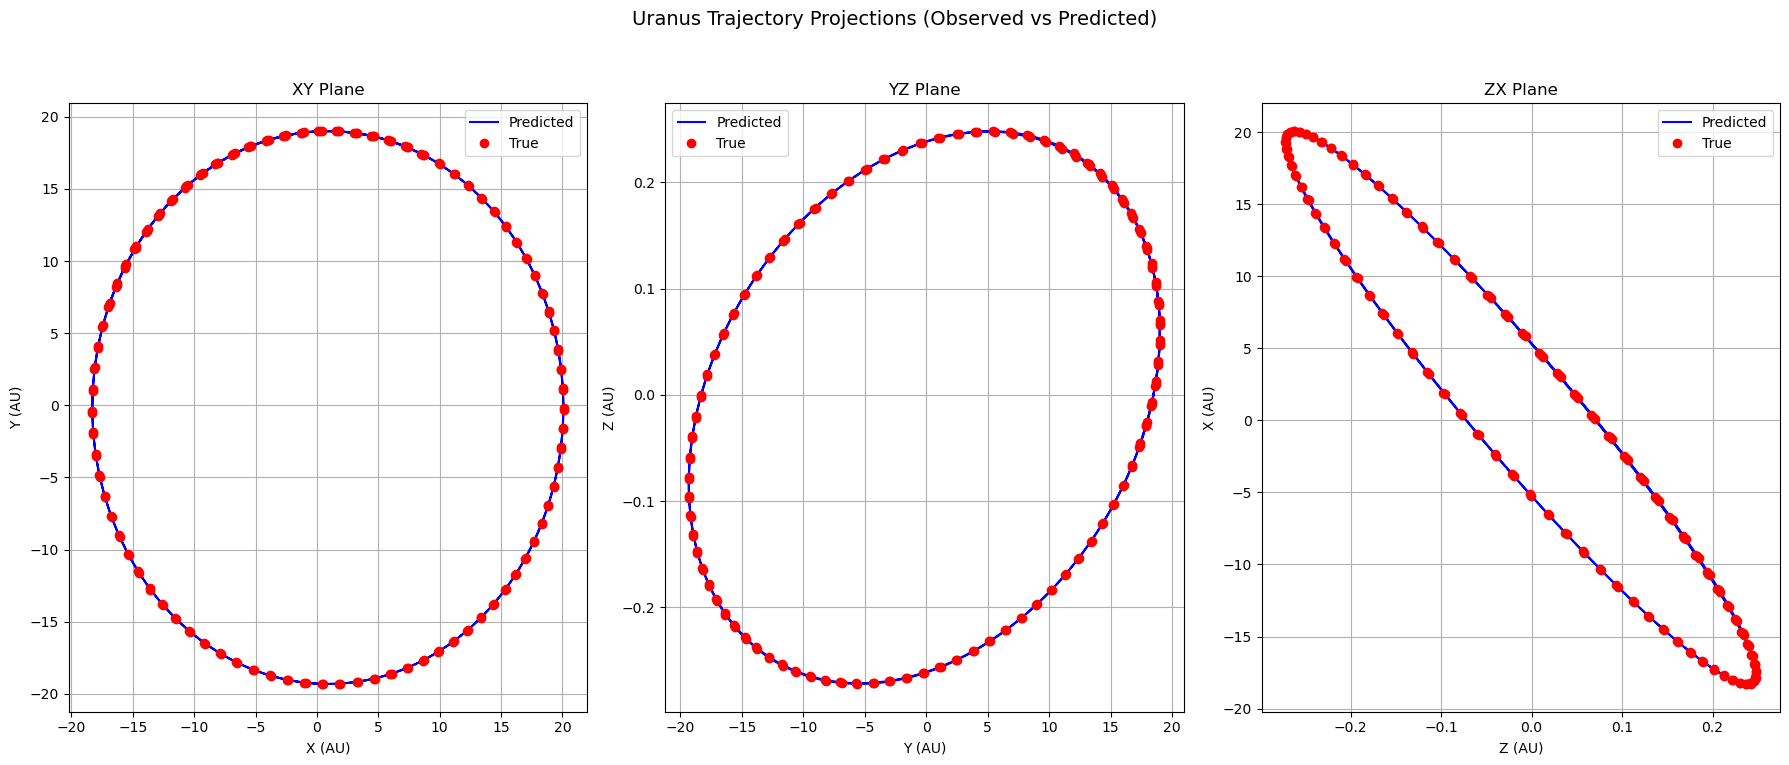

In [11]:
from neptune_deterministic_methods import plot_uranus_orbits

predicted_uranus_trajectory = predict_U(result_unscaled, T = T, dt = dt)

plot_uranus_orbits(predicted_uranus_trajectory, U_true, T)

Computing trajectories...: 100%|██████████| 69350/69350 [00:00<00:00, 155185.71it/s]


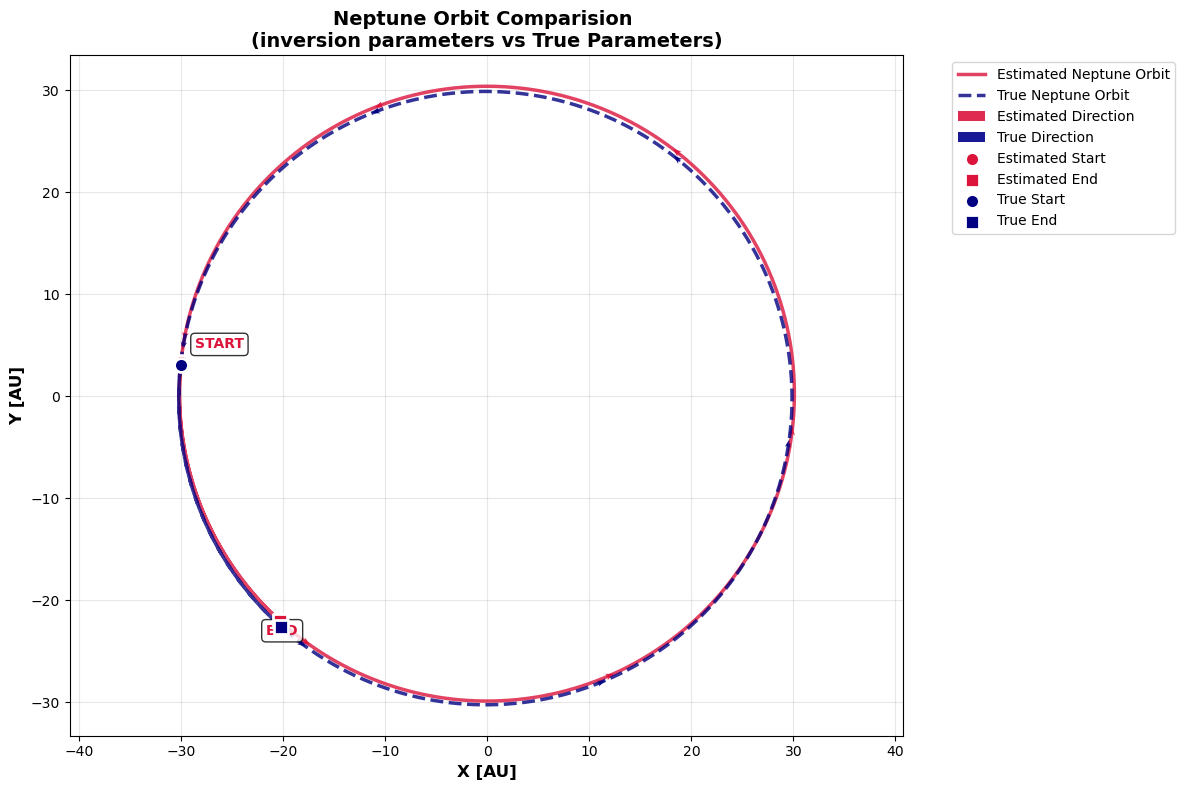

Estimated orbit: 69351 points
True orbit: 69351 points
Number of direction arrows per orbit: 8
Orbital direction: Start (circle) → End (square)


In [12]:
from setup_inversion import get_arrow_data
from neptune_deterministic_methods import plot_neptune_orbits

plot_neptune_orbits(result_unscaled, initial_conditions, T = T, dt = 1)

## 3.3 Using Regularisation to get the best regularisation parameter.

- In the following cells, we are going to demonstrate how `CoFI` can be used to plot the regularisation curve or **L-Curve** in order to get the best regularisation parameter for our inversion.


- This will ensure that our model inferred i.e the parameters of Neptune are meaningfull and the trajectories are not overshooting.


- We will then use the best regularisation parameter, inferred from our synthetic data, for running our final inversion on real data.

- Note that the results may differ depending on where the method starts the inversion and therefore one may not get the exact same l-curve.

In [13]:
alphas = np.logspace(-4, 2, 20)

In [14]:
import cofi
from neptune_deterministic_methods import callback_func, set_lcurve_inversion_params
alphas = np.logspace(-4, 2, 10)
lcurve_problems = []
m_start = initial_conditions['Neptune'].copy()
m_start = scale_param(m_start)

for alpha in alphas:
    
    inv_problem_alpha = BaseProblem()
    inv_problem_alpha.name = f"Neptune Orbit Determination alpha={alpha}"
    inv_problem_alpha.set_data(U_true)
    inv_problem_alpha.set_forward(predict_U, args = [T, dt])
    inv_problem_alpha.set_initial_model(np.atleast_1d(m_start_scaled))
    inv_problem_alpha.set_residual(residual, args = (U_true, alpha, T, dt))  # Pass U_true as an argument to residual function
    inv_problem_alpha.set_jacobian(jacobian, args = (U_true, alpha, T, dt))  # Pass U_true and alpha as arguments to jacobian function
    lcurve_problems.append(inv_problem_alpha)
    
    
inv_options_alpha = InversionOptions()
inv_options_alpha.set_tool("scipy.optimize.least_squares")
inv_options_alpha.set_params(
    bounds=(bounds_lower_scaled, bounds_upper_scaled),
    method="trf",
    max_nfev=100,
    # verbose=2, 
    ftol=1e-14,
    xtol=1e-14
)


inversion_pool = cofi.utils.InversionPool(
    list_of_inv_problems=lcurve_problems,
    list_of_inv_options=inv_options_alpha,
    callback=callback_func,
    parallel=False,  # Use parallel processing if available, works only in Windows/linux due to Multiprocessing library not being able to pickle up the forward model on MacOS
    
)

In [15]:
all_res, all_cb_returns = inversion_pool.run()

l_curve_points = list(zip(*all_cb_returns))
residual_norm, regularization_norm = np.array(l_curve_points)

Computing trajectories...: 100%|██████████| 68985/68985 [00:00<00:00, 153842.59it/s]



Synthetic data ranges:
X: -18.298 to 20.084 (range: 38.383)
Y: -19.319 to 19.019 (range: 38.337)
Z: -0.272199 to 0.248322 (range: 0.520521)

Noisy synthetic data ranges:
X: -18.298 to 20.083 (range: 38.382)
Y: -19.318 to 19.019 (range: 38.338)
Z: -0.272182 to 0.248330 (range: 0.520512)
Alpha 1.00e-04 - Residual norm: 0.042027, Solution norm: 5.955405


Computing trajectories...: 100%|██████████| 68985/68985 [00:00<00:00, 154168.83it/s]



Synthetic data ranges:
X: -18.298 to 20.084 (range: 38.383)
Y: -19.319 to 19.019 (range: 38.337)
Z: -0.272199 to 0.248322 (range: 0.520521)

Noisy synthetic data ranges:
X: -18.297 to 20.084 (range: 38.381)
Y: -19.319 to 19.019 (range: 38.338)
Z: -0.272195 to 0.248339 (range: 0.520534)
Alpha 4.64e-04 - Residual norm: 0.034319, Solution norm: 5.956548


Computing trajectories...: 100%|██████████| 68985/68985 [00:00<00:00, 143769.95it/s]



Synthetic data ranges:
X: -18.298 to 20.084 (range: 38.383)
Y: -19.319 to 19.019 (range: 38.337)
Z: -0.272199 to 0.248322 (range: 0.520521)

Noisy synthetic data ranges:
X: -18.299 to 20.085 (range: 38.385)
Y: -19.318 to 19.018 (range: 38.336)
Z: -0.272212 to 0.248322 (range: 0.520534)
Alpha 2.15e-03 - Residual norm: 0.038879, Solution norm: 5.967295


Computing trajectories...: 100%|██████████| 68985/68985 [00:00<00:00, 151976.48it/s]



Synthetic data ranges:
X: -18.298 to 20.084 (range: 38.383)
Y: -19.319 to 19.019 (range: 38.337)
Z: -0.272199 to 0.248322 (range: 0.520521)

Noisy synthetic data ranges:
X: -18.298 to 20.084 (range: 38.382)
Y: -19.319 to 19.018 (range: 38.336)
Z: -0.272180 to 0.248319 (range: 0.520498)
Alpha 1.00e-02 - Residual norm: 0.020111, Solution norm: 5.947475


Computing trajectories...: 100%|██████████| 68985/68985 [00:00<00:00, 155707.15it/s]



Synthetic data ranges:
X: -18.298 to 20.084 (range: 38.383)
Y: -19.319 to 19.019 (range: 38.337)
Z: -0.272199 to 0.248322 (range: 0.520521)

Noisy synthetic data ranges:
X: -18.299 to 20.084 (range: 38.383)
Y: -19.319 to 19.020 (range: 38.338)
Z: -0.272211 to 0.248328 (range: 0.520540)
Alpha 4.64e-02 - Residual norm: 0.032725, Solution norm: 5.936739


Computing trajectories...: 100%|██████████| 68985/68985 [00:00<00:00, 153149.55it/s]



Synthetic data ranges:
X: -18.298 to 20.084 (range: 38.383)
Y: -19.319 to 19.019 (range: 38.337)
Z: -0.272199 to 0.248322 (range: 0.520521)

Noisy synthetic data ranges:
X: -18.298 to 20.085 (range: 38.383)
Y: -19.319 to 19.019 (range: 38.338)
Z: -0.272203 to 0.248322 (range: 0.520525)
Alpha 2.15e-01 - Residual norm: 0.108887, Solution norm: 5.704447


Computing trajectories...: 100%|██████████| 68985/68985 [00:00<00:00, 154478.89it/s]



Synthetic data ranges:
X: -18.298 to 20.084 (range: 38.383)
Y: -19.319 to 19.019 (range: 38.337)
Z: -0.272199 to 0.248322 (range: 0.520521)

Noisy synthetic data ranges:
X: -18.299 to 20.085 (range: 38.384)
Y: -19.317 to 19.019 (range: 38.336)
Z: -0.272205 to 0.248325 (range: 0.520530)
Alpha 1.00e+00 - Residual norm: 0.183544, Solution norm: 0.464760


Computing trajectories...: 100%|██████████| 68985/68985 [00:00<00:00, 152137.01it/s]



Synthetic data ranges:
X: -18.298 to 20.084 (range: 38.383)
Y: -19.319 to 19.019 (range: 38.337)
Z: -0.272199 to 0.248322 (range: 0.520521)

Noisy synthetic data ranges:
X: -18.297 to 20.085 (range: 38.382)
Y: -19.318 to 19.019 (range: 38.337)
Z: -0.272192 to 0.248321 (range: 0.520513)
Alpha 4.64e+00 - Residual norm: 0.179220, Solution norm: 0.277522


Computing trajectories...: 100%|██████████| 68985/68985 [00:00<00:00, 154795.34it/s]



Synthetic data ranges:
X: -18.298 to 20.084 (range: 38.383)
Y: -19.319 to 19.019 (range: 38.337)
Z: -0.272199 to 0.248322 (range: 0.520521)

Noisy synthetic data ranges:
X: -18.298 to 20.086 (range: 38.384)
Y: -19.317 to 19.019 (range: 38.337)
Z: -0.272209 to 0.248335 (range: 0.520544)
Alpha 2.15e+01 - Residual norm: 0.154604, Solution norm: 0.406010


Computing trajectories...: 100%|██████████| 68985/68985 [00:00<00:00, 152535.30it/s]



Synthetic data ranges:
X: -18.298 to 20.084 (range: 38.383)
Y: -19.319 to 19.019 (range: 38.337)
Z: -0.272199 to 0.248322 (range: 0.520521)

Noisy synthetic data ranges:
X: -18.300 to 20.085 (range: 38.385)
Y: -19.317 to 19.019 (range: 38.336)
Z: -0.272193 to 0.248311 (range: 0.520504)
Alpha 1.00e+02 - Residual norm: 69.810800, Solution norm: 0.898208


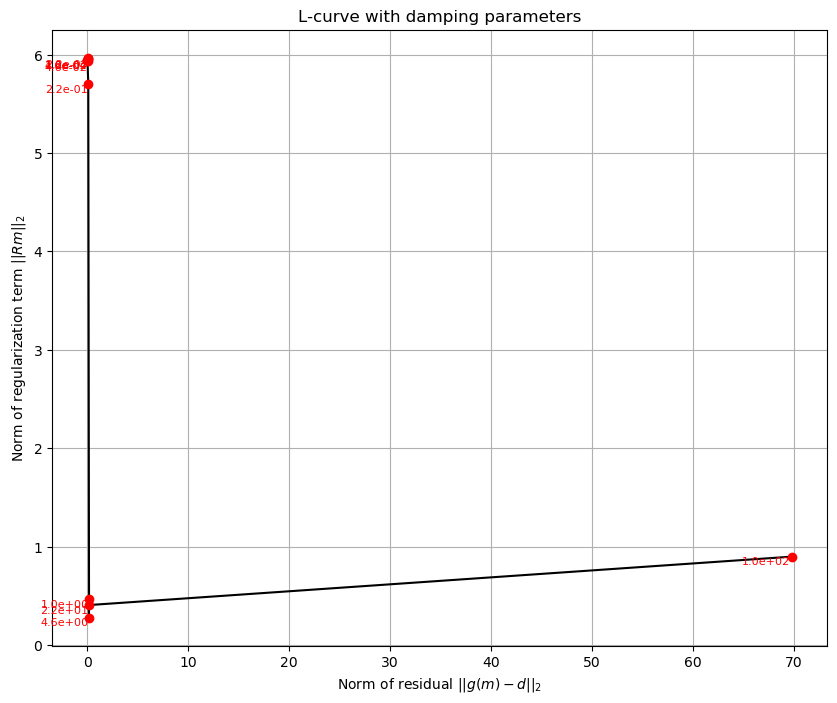

In [16]:
plt.figure(figsize=(10, 8))
plt.plot(residual_norm, regularization_norm, 'k.-')
plt.xlabel(r'Norm of residual $||g(m)-d||_2$')
plt.ylabel(r'Norm of regularization term $||Rm||_2$')

for damping, res_norm, reg_norm in zip(alphas, residual_norm, regularization_norm):
    plt.plot(res_norm, reg_norm, 'ro')
    plt.text(
        res_norm - res_norm * 2e-3,
        reg_norm - reg_norm * 2e-3,
        s=f"{damping:.1e}",  # Label as scientific notation
        va='top',
        ha='right',
        fontsize=8,
        color='r'
    )

plt.title("L-curve with damping parameters")
plt.grid(True)
plt.show()

## 4. Real Data Inversion

- We then apply our deterministic inversion via CoFI on actual observational data obtained from [NASA JPL Horizons](https://ssd.jpl.nasa.gov/horizons/app.html#/).

- The data consists of geometric Cartesian position and velocity vectors of **Uranus**, relative to the **Solar System Barycenter**, with the following settings:

  - **Target body**: Uranus (799)  
  - **Center body**: Solar System Barycenter (0)  
  - **Reference frame**: Ecliptic of J2000.0  
  - **Time span**: A.D. 1775-Jan-01 to 2125-Jan-02  
  - **Step size**: 1 calendar year  
  - **Output format**: Cartesian position and velocity (AU, AU/day)  
  - **Output type**: GEOMETRIC states  
  - **Calendar mode**: Mixed Julian/Gregorian  
  - **Ephemeris source**: `ura183_merged` (Uranus), `DE441` (Solar System)

This dataset provides real-world observations to test the robustness of our inversion pipeline.


In [17]:
#uncomment to install the astroquery package
# !pip install astroquery

In [18]:
from astroquery.jplhorizons import Horizons     
from neptune_deterministic_methods import get_actual_data   
T = 190
dt = 1
U_true = get_actual_data(z_scaling=False, T=T)

m_0 = set_true_m()

initial_conditions = set_initial_conditions()
PARAM_BOUNDS = get_param_bounds()
PARAM_SCALES = get_param_scales()
INVERT_INDICES = get_inversion_indices()
STARTING_POINTS = get_starting_points()

validate_config()

Original data ranges:
X: -18.297 to 20.085 (range: 38.382)
Y: -19.319 to 19.013 (range: 38.332)
Z: -0.272231 to 0.248352 (range: 0.520583)

Z scaling is disabled, using original Z values.
Inverting for: ['mass', 'x', 'y', 'z', 'vx', 'vy', 'vz']
Starting points: [5.129494593915012e-05, -29.91585533802299, 3.145551080953517, 0.1050744172524112, -0.0002804329678559355, -0.00311021549555015, 4.187313350941659e-05]


In [19]:
m_start_scaled = scale_param(np.array(STARTING_POINTS))
if len(INVERT_INDICES) == 1:
    Nmstart_scaled = m_start_scaled.item() if hasattr(m_start_scaled, 'item') else m_start_scaled

print(f"\nStarting points (unscaled): {STARTING_POINTS}")
print(f"Starting points (scaled): {m_start_scaled}")

print("\nTesting forward function...")
try:
    pred_test = predict_U(m_start_scaled, T=T, dt=dt, z_scale_factor=z_scale_factor)
    residual_test = residual(m_start_scaled, U_true, T=T, dt=dt)
    print(f"Initial residual norm: {np.linalg.norm(residual_test):.6f}")
    print(f"Residual by component:")
    print(f"  X component: {np.linalg.norm(residual_test[:T]):.6f}")
    print(f"  Y component: {np.linalg.norm(residual_test[T:2*T]):.6f}")
    print(f"  Z component: {np.linalg.norm(residual_test[2*T:]):.6f}")
except Exception as e:
    print(f"Forward function test failed: {e}")
    import traceback
    traceback.print_exc()


Starting points (unscaled): [5.129494593915012e-05, -29.91585533802299, 3.145551080953517, 0.1050744172524112, -0.0002804329678559355, -0.00311021549555015, 4.187313350941659e-05]
Starting points (scaled): [ 1.83825353e-04 -4.59414276e+00  4.33575690e-01  6.82916330e-02
 -2.24204674e-01 -3.74160049e+00  2.81992340e-03]

Testing forward function...
Initial residual norm: 1.501377
Residual by component:
  X component: 1.098035
  Y component: 1.023848
  Z component: 0.013735


In [20]:
alpha = 2.2e-1  # from the l curve

inv_problem = BaseProblem()
inv_problem.name = "Neptune Orbit Determination - Config Driven"
inv_problem.set_data(U_true)
inv_problem.set_forward(predict_U, args = [T, dt])
inv_problem.set_initial_model(np.atleast_1d(m_start_scaled))
inv_problem.set_residual(residual, args = (U_true, alpha, T, dt))  # Pass U_true as an argument to residual function
inv_problem.set_jacobian(jacobian, args = (U_true, alpha, T, dt))  # Pass U_true as an argument to jacobian function
bounds_lower_scaled = scale_param(np.array([bound[0] for bound in PARAM_BOUNDS]))
bounds_upper_scaled = scale_param(np.array([bound[1] for bound in PARAM_BOUNDS]))

inv_options = InversionOptions()
inv_options.set_tool("scipy.optimize.least_squares")
inv_options.set_params(
    bounds=(bounds_lower_scaled, bounds_upper_scaled),    # Uncomment to use bounds when using trust region reflective method
    method="trf",   # Trust Region Reflective method, you can also try 'lm' (Levenberg-Marquardt) if you prefer
    max_nfev=100,
    verbose=2,
    ftol=1e-12,
    xtol=1e-12
)

print("\nRunning inversion...")
try:
    inv = Inversion(inv_problem, inv_options)
    inv_result = inv.run()
    result = inv_result.model
    result_unscaled = unscale_param(result)
    
    print("\n" + "="*50)
    print("RESULTS")
    print("="*50)
    
    param_names = ['mass', 'x', 'y', 'z', 'vx', 'vy', 'vz']
    result_unscaled = np.atleast_1d(result_unscaled)
    
    print("\nInverted parameters:")
    for i, param_idx in enumerate(INVERT_INDICES):
        param_name = param_names[param_idx]
        estimated = result_unscaled[i]
        true_val = m_0[param_idx]
        starting = STARTING_POINTS[i]
        
        print(f"  {param_name}: {estimated:.6e} (true: {true_val:.6e}, started: {starting:.6e})")
    
    final_pred = predict_U(result, T, dt)
    final_residual = U_true - final_pred
    print(f"\nFinal residual norm: {np.linalg.norm(final_residual):.6f}")
    print(f"Final residual by component:")
    print(f"  X component: {np.linalg.norm(final_residual[:T]):.6f}")
    print(f"  Y component: {np.linalg.norm(final_residual[T:2*T]):.6f}")
    print(f"  Z component: {np.linalg.norm(final_residual[2*T:]):.6f}")
    
    print(f'initial residual norm: {np.linalg.norm(residual(m_start_scaled, U_true)):.6f}')
    print(f'final residual norm: {np.linalg.norm(final_residual):.6f}')
    
    
    if 0 in INVERT_INDICES:
        mass_idx = INVERT_INDICES.index(0)
        neptune_mass = result_unscaled[mass_idx]
        print(f"\nEstimated Neptune mass: {neptune_mass:.6e} solar masses")
        print(f"Estimated Neptune mass: {neptune_mass * 1.989e30:.6e} kg")
    
    print("Inversion completed successfully!")
    print("="*50)
    
except Exception as e:
    print(f"Inversion failed: {e}")
    import traceback
    traceback.print_exc()



Running inversion...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.9825e+00                                    2.19e+02    
       1              4         1.9517e+00      3.08e-02       8.92e-02       2.57e+02    
       2              5         1.9416e+00      1.01e-02       2.23e-02       5.20e+01    
       3             21         1.9416e+00      0.00e+00       0.00e+00       5.20e+01    
`xtol` termination condition is satisfied.
Function evaluations 21, initial cost 1.9825e+00, final cost 1.9416e+00, first-order optimality 5.20e+01.

RESULTS

Inverted parameters:
  mass: 1.842532e-05 (true: 5.151000e-05, started: 5.129495e-05)
  x: -2.967524e+01 (true: -3.005587e+01, started: -2.991586e+01)
  y: 3.490167e+00 (true: 3.108514e+00, started: 3.145551e+00)
  z: 7.000961e-02 (true: 6.280746e-01, started: 1.050744e-01)
  vx: -2.956188e-04 (true: -3.404730e-04, started: -2.804330e-04)
  vy: -3.080679e-03 (tr

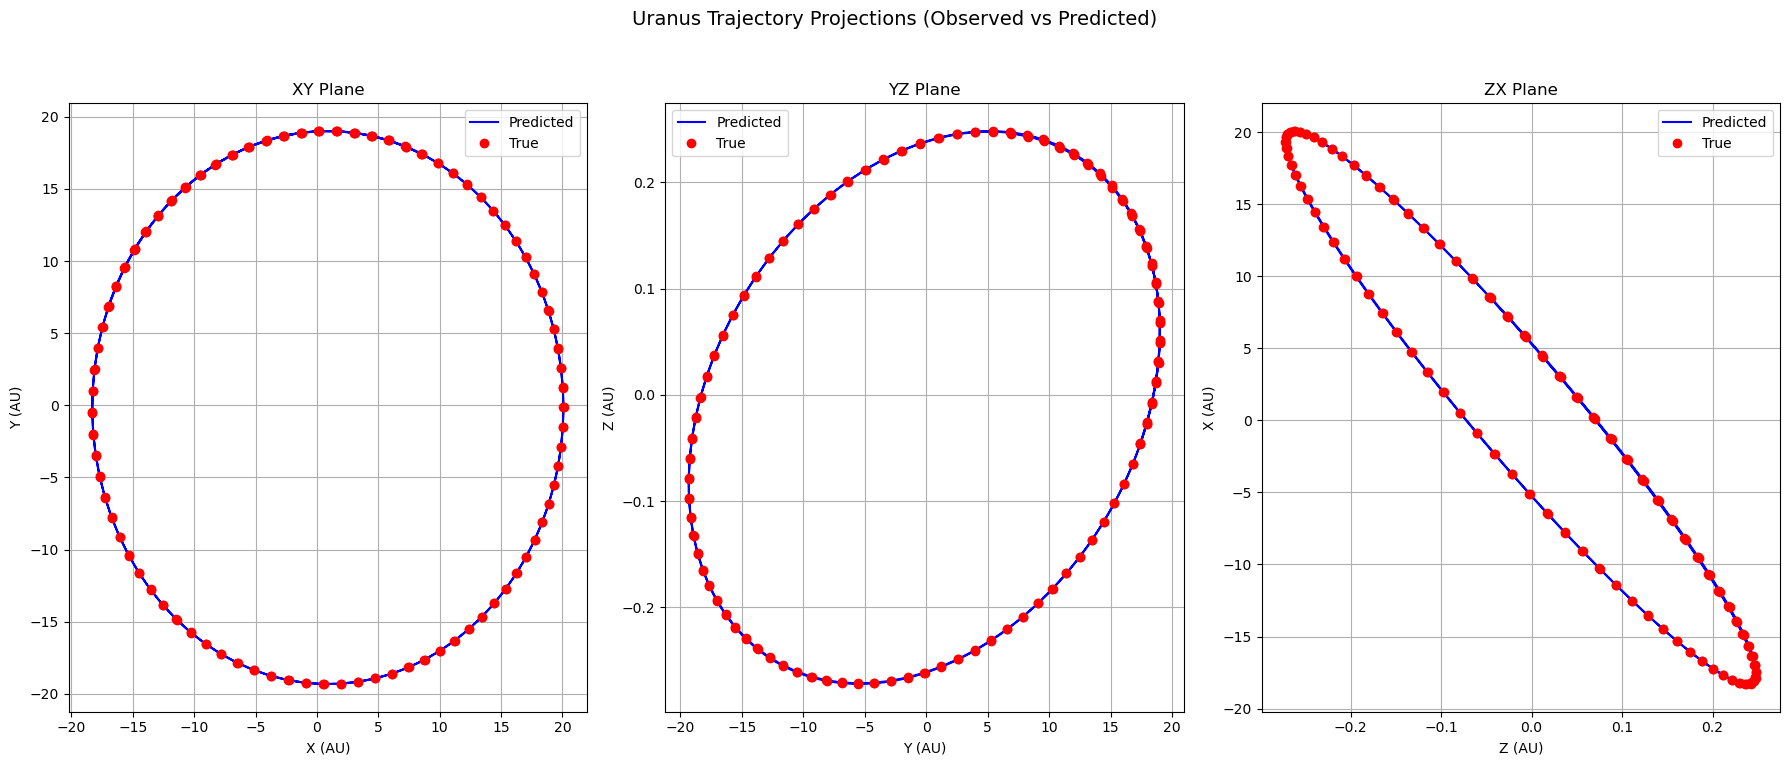

In [21]:
predicted_uranus_trajectory = predict_U(result_unscaled, T = T, dt = dt)

plot_uranus_orbits(predicted_uranus_trajectory, U_true, T)

Computing trajectories...: 100%|██████████| 69350/69350 [00:00<00:00, 155879.13it/s]


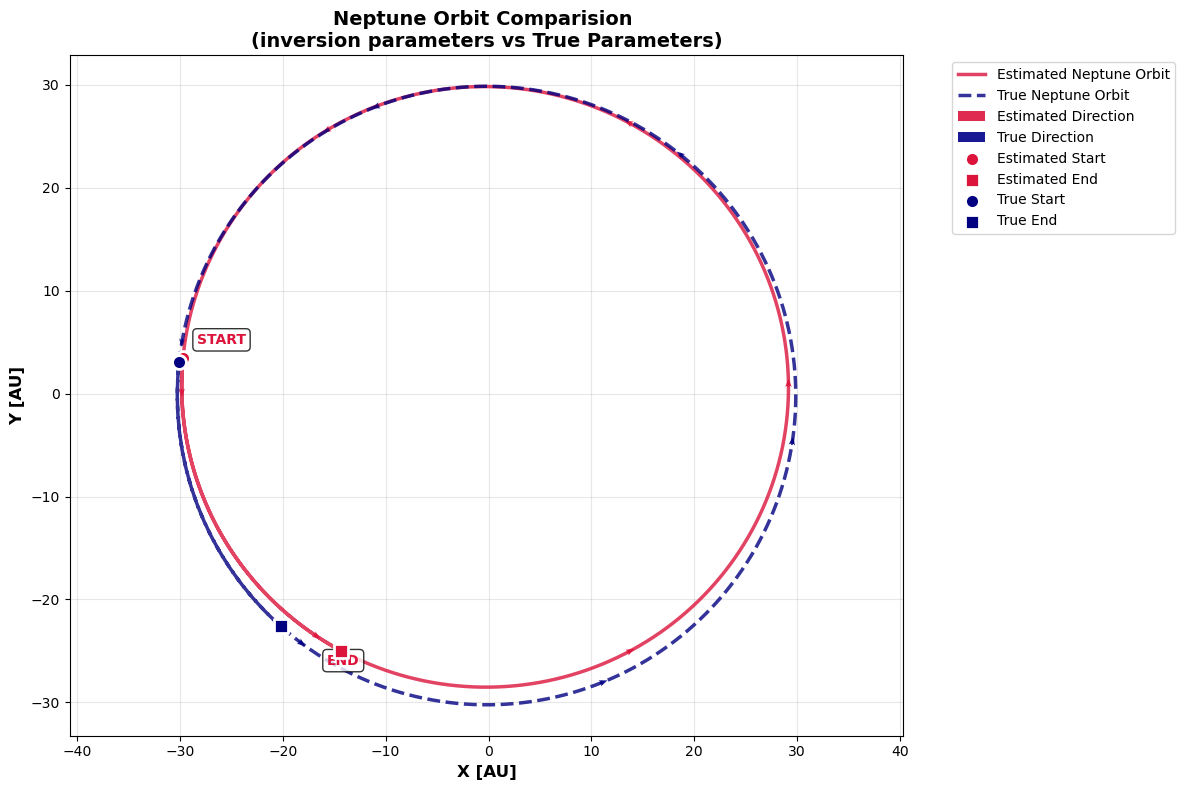

Estimated orbit: 69351 points
True orbit: 69351 points
Number of direction arrows per orbit: 8
Orbital direction: Start (circle) → End (square)


In [22]:
from setup_inversion import get_arrow_data
from neptune_deterministic_methods import plot_neptune_orbits

plot_neptune_orbits(result_unscaled, initial_conditions, T = T, dt = 1)

# 5. Watermark

- For version of libraries used.

In [23]:
watermark_list = ["numba", "cofi", "tqdm", "numpy", "matplotlib", "astroquery"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))


numba 0.61.0
cofi 0.2.10
tqdm 4.67.1
numpy 2.1.3
matplotlib 3.10.1
astroquery 0.4.10
